In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")

Loaded 96 model fit results
Participants: ['HH', 'as', 'dt', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'fusionOnly_sharedPrior', 'gaussian_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_contextualPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'probabilityMatching_sharedPrior']


In [9]:
# Create comprehensive comparison table
def create_model_comparison_table(df_results):
    """Create a detailed comparison table of all model fits"""
    
    # Pivot table to compare models side by side
    comparison_cols = ['AIC', 'BIC', 'logLikelihood', 'n_conditions']
    
    summary_table = df_results.pivot_table(
        index='participantID', 
        columns='modelType', 
        values=comparison_cols,
        aggfunc='first'
    )
    
    return summary_table

# Create the comparison table
comparison_table = create_model_comparison_table(df_results)
comparison_table_df=comparison_table.copy()
comparison_table_df

AIC                         \
modelType     fusionOnlyLogNorm_sharedPrior fusionOnly_sharedPrior   
participantID                                                        
HH                              1763.001842            1793.602122   
as                              2254.991740            2263.345437   
dt                              2552.244249            2565.341083   
ip                              2407.759053            2460.905237   
ln1                             1166.138527            1155.994138   
ln2                             2175.843076            2202.909958   
mh                              2449.104495            2484.289394   
ml                              2541.010802            2511.040793   
mt                              2222.181530            2229.582293   
oy                              2327.919254            2349.704795   
qs                              2508.874429            2544.869563   
sx                              2174.470005            2152.265325   

                                                                  \
modelType     gaussian_sharedPrior logLinearMismatch_sharedPrior   
participantID                                                      
HH                     1797.673451                   1773.816782   
as                     2277.986338                   2267.678639   
dt                     2566.280398                   2559.242249   
ip                     2449.284500                   2415.656094   
ln1                    1168.460109                   1187.446115   
ln2                    2208.596516                   2187.439502   
mh                     2485.255421                   2440.958873   
ml                     2512.028631                   2547.796173   
mt                     2212.417194                   2210.646225   
oy                     2347.045722                   2342.185560   
qs                     2538.966381                   2512.368823   
sx                     2162.279536                   2169.746267   

                                                           \
modelType     lognorm_contextualPrior lognorm_sharedPrior   
participantID                                               
HH                        1754.989422         1755.433047   
as                        2263.121318         2275.893994   
dt                        2560.158634         2550.059241   
ip                        2411.827519         2419.753292   
ln1                       1175.271027         1195.044249   
ln2                       2187.972030         2187.435979   
mh                        2432.071672         2441.617131   
ml                        2510.857864         2518.167316   
mt                        2203.133573         2213.757227   
oy                        2339.644664         2343.827826   
qs                        2505.856238         2503.008533   
sx                        2163.218901         2167.727072   

                                                      \
modelType     probabilityMatchingLogNorm_sharedPrior   
participantID                                          
HH                                       1762.551518   
as                                       2257.249719   
dt                                       2555.987604   
ip                                       2416.772922   
ln1                                      1180.279951   
ln2                                      2179.061033   
mh                                       2439.252848   
ml                                       2527.224118   
mt                                       2206.329362   
oy                                       2338.398932   
qs                                       2509.614359   
sx                                       2162.374998   

                                                                        BIC  \
modelType     probabilityMatching_sharedPrior fusionOnlyLogNorm_sharedPrior   
participantID                                        

In [7]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model lognorm_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=15.46, ΔBIC=28.23
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=17.48, ΔBIC=30.25
Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=22.20, ΔBIC=22.20
Participant sx, Model probabilityMatching_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=4.29, ΔBIC=17.06
Participant sx, Model lognorm_contextualPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=10.95, ΔBIC=27.98
Participant sx, Model gaussian_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=10.01, ΔBIC=22.79
Participant sx, Model probabilityMatchingLogNorm_sharedPrior vs Best Model fusionOnly_sharedPrior: ΔAIC=10.11, ΔBIC=22.88
Participant mt, Model lognorm_sharedPrior vs Best Model lognorm_contextualPrior: ΔAIC=10.62, ΔBIC=6.74
Participant mt, Model fusionOnlyLogNorm_sharedPrior vs Best Model lognorm_contextualPrior: ΔAIC=19.05, ΔBIC=3.53
Particip

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'dt': 60.62101904721794, 'as': 89.49096550592958, 'mt': 89.60826311118126, 'sx': 90.51560030672181, 'ml': 113.49940643036871, 'oy': 115.49714176808538, 'ln2': 127.58039819566739, 'qs': 138.0356494501566, 'ln1': 145.53547158896868, 'HH': 158.1253215275633, 'ip': 170.5725506098156, 'mh': 213.52220546627996}


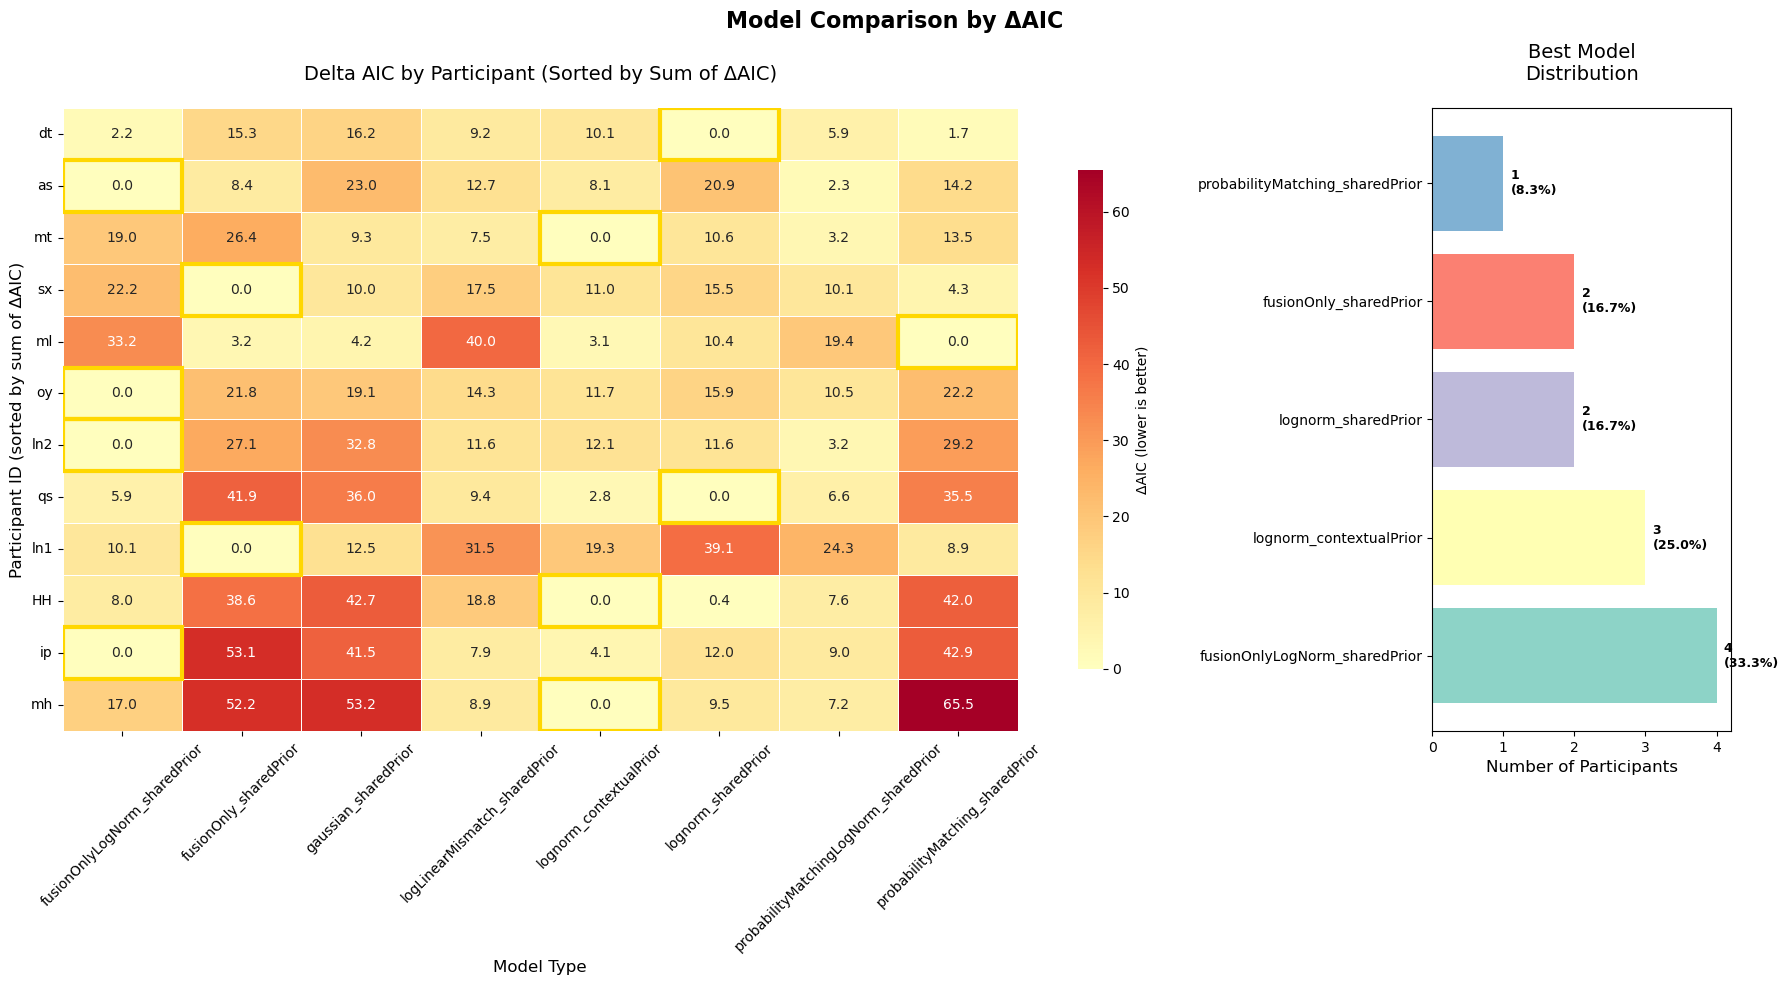


PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)
Rank Participant  Sum ΔAIC   Best Model         Min ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    dt           60.6       lognorm_sharedPrior 0.0        Poor fit       
2    as           89.5       fusionOnlyLogNorm_sharedPrior 0.0        Poor fit       
3    mt           89.6       lognorm_contextualPrior 0.0        Poor fit       
4    sx           90.5       fusionOnly_sharedPrior 0.0        Poor fit       
5    ml           113.5      probabilityMatching_sharedPrior 0.0        Poor fit       
6    oy           115.5      fusionOnlyLogNorm_sharedPrior 0.0        Poor fit       
7    ln2          127.6      fusionOnlyLogNorm_sharedPrior 0.0        Poor fit       
8    qs           138.0      lognorm_sharedPrior 0.0        Poor fit       
9    ln1          145.5      fusionOnly_sharedPrior 0.0        Poor fit       
10   HH           158.1      

In [8]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results):
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔAIC', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔAIC (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta AIC by Participant (Sorted by Sum of ΔAIC)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔAIC)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # # Add legend explaining the gold borders
    # ax1.text(0.02, 0.98, '★ Gold border = Best model for participant', 
    #          transform=ax1.transAxes, fontsize=10, 
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.7),
    #          verticalalignment='top')
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔAIC':<10} {'Best Model':<18} {'Min ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        min_delta_aic = participant_data['delta_AIC'].min()
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results)